In [1]:
%pip install yfinance pandas numpy matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

# Jupyter inline plots
%matplotlib inline


def fetch_data_yfinance(ticker: str, period: str = "2y") -> pd.DataFrame:
    """
    Fetch daily price data from yfinance.
    """
    data = yf.download(ticker, period=period, interval="1d", auto_adjust=True)
    if data.empty:
        raise ValueError(f"No data returned for ticker '{ticker}'.")
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    return data


def add_returns_and_rolling_vol(data: pd.DataFrame) -> pd.DataFrame:
    """
    Add log returns and rolling annualized volatility (20, 60, 120 days).
    """
    df = data.copy()
    df['return'] = np.log(df['Close'] / df['Close'].shift(1))

    for window in [20, 60, 120]:
        col_name = f'vol_{window}'
        df[col_name] = df['return'].rolling(window).std() * np.sqrt(252)

    df['vol_avg_20'] = df['Volume'].rolling(20).mean()
    return df


def add_volatility_clusters(data: pd.DataFrame, n_clusters: int = 3) -> pd.DataFrame:
    """
    Use KMeans clustering on vol_20 and vol_60 to label volatility regimes.
    """
    df = data.copy()
    features = df[['vol_20', 'vol_60']].dropna()

    if features.empty:
        df['cluster'] = np.nan
        return df

    scaler = StandardScaler()
    X = scaler.fit_transform(features)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X)

    cluster_series = pd.Series(index=features.index, data=clusters)
    df['cluster'] = cluster_series

    return df


def add_volatility_anomalies(data: pd.DataFrame, contamination: float = 0.02) -> pd.DataFrame:
    """
    Use IsolationForest to detect abnormal volatility days (based on returns and vol_20).
    anomaly = -1 (anomaly), 1 (normal).
    """
    df = data.copy()
    features = df[['return', 'vol_20']].dropna()

    if features.empty:
        df['anomaly'] = np.nan
        return df

    iso = IsolationForest(contamination=contamination, random_state=42)
    labels = iso.fit_predict(features)

    anomaly_series = pd.Series(index=features.index, data=labels)
    df['anomaly'] = anomaly_series

    return df


In [3]:
def plot_all_in_one(df, ticker: str):
    """
    Show multiple volatility-related graphs in a single figure
    using subplots (3 x 2 grid).
    """
    df = df.copy()
    returns = df['return'].dropna()

    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    fig.suptitle(f"{ticker} Volatility Dashboard", fontsize=16)
    fig.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)

    # (1) Price + 20d vol (top-left)
    ax1 = axes[0, 0]
    ax1.plot(df.index, df['Close'], label='Price')
    ax1.set_title("Price & 20d Volatility")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price")

    ax1b = ax1.twinx()
    ax1b.plot(df.index, df['vol_20'], linestyle='--', label='20d Volatility')
    ax1b.set_ylabel("Annualized Volatility (20d)")

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1b.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    # (2) 20 / 60 / 120d vol (top-right)
    ax2 = axes[0, 1]
    ax2.plot(df.index, df['vol_20'], label='20d')
    ax2.plot(df.index, df['vol_60'], label='60d')
    ax2.plot(df.index, df['vol_120'], label='120d')
    ax2.set_title("Multi-Window Rolling Volatility")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Annualized Volatility")
    ax2.legend()

    # (3) Return histogram (middle-left)
    ax3 = axes[1, 0]
    ax3.hist(returns, bins=50)
    ax3.set_title("Daily Log Returns Distribution")
    ax3.set_xlabel("Daily Log Return")
    ax3.set_ylabel("Frequency")

    # (4) Vol_20 vs Volume scatter (middle-right)
    ax4 = axes[1, 1]
    sub_scatter = df[['vol_20', 'Volume', 'cluster']].dropna()
    if not sub_scatter.empty:
        sc = ax4.scatter(
            sub_scatter['vol_20'],
            sub_scatter['Volume'],
            c=sub_scatter['cluster'],
            cmap='viridis'
        )
        ax4.set_title("20d Volatility vs Volume (Clusters)")
        ax4.set_xlabel("20d Annualized Volatility")
        ax4.set_ylabel("Volume")
        cbar = fig.colorbar(sc, ax=ax4)
        cbar.set_label("Cluster")
    else:
        ax4.set_title("20d Vol vs Volume (no cluster data)")
        ax4.set_xlabel("20d Annualized Volatility")
        ax4.set_ylabel("Volume")

    # (5) Price by regime (bottom-left)
    ax5 = axes[2, 0]
    sub_regime = df[['Close', 'cluster']].dropna()
    if not sub_regime.empty:
        for cluster_id in sorted(sub_regime['cluster'].unique()):
            mask = sub_regime['cluster'] == cluster_id
            ax5.plot(
                sub_regime.index[mask],
                sub_regime['Close'][mask],
                marker='o',
                linestyle='-',
                label=f"Cluster {cluster_id}",
                markersize=2
            )
        ax5.set_title("Price by Volatility Regime (Clusters)")
        ax5.set_xlabel("Date")
        ax5.set_ylabel("Price")
        ax5.legend()
    else:
        ax5.set_title("Price by Volatility Regime (no clusters)")
        ax5.set_xlabel("Date")
        ax5.set_ylabel("Price")
        ax5.plot(df.index, df['Close'])

    # (6) 20d vol + anomalies (bottom-right)
    ax6 = axes[2, 1]
    ax6.plot(df.index, df['vol_20'], label='20d Vol')

    sub_anom = df[['vol_20', 'anomaly']].dropna()
    if not sub_anom.empty:
        anomaly_dates = sub_anom.index[sub_anom['anomaly'] == -1]
        ax6.scatter(
            anomaly_dates,
            df.loc[anomaly_dates, 'vol_20'],
            s=30
        )
        ax6.set_title("20d Volatility (Red = Anomalies)")
    else:
        ax6.set_title("20d Volatility (no anomalies)")

    ax6.set_xlabel("Date")
    ax6.set_ylabel("Annualized Volatility (20d)")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


[*********************100%***********************]  1 of 1 completed


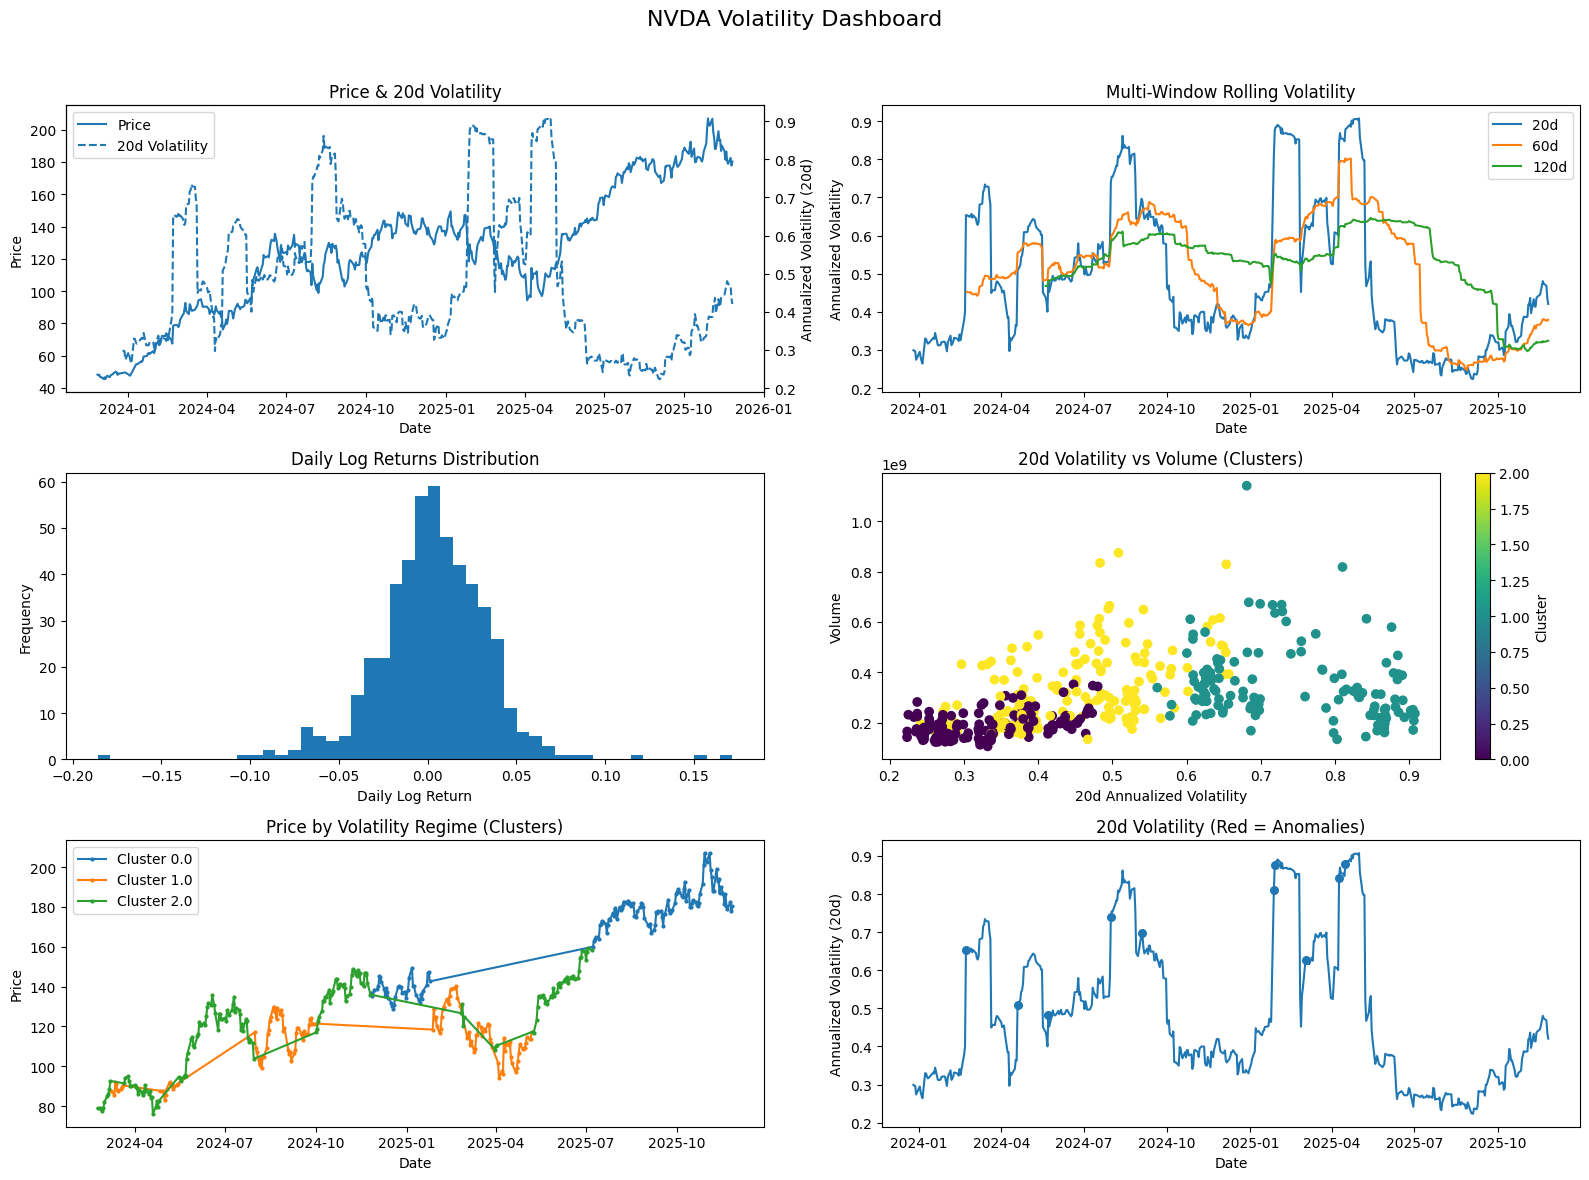

In [4]:
ticker = "NVDA"   # change this to TSLA, MSFT, etc.
period = "2y"     # or "5y", "1y"

# 1. Fetch data
data = fetch_data_yfinance(ticker, period=period)

# 2. Add features
data = add_returns_and_rolling_vol(data)

# 3. Add clusters
data = add_volatility_clusters(data, n_clusters=3)

# 4. Add anomaly flags
data = add_volatility_anomalies(data, contamination=0.02)

# 5. Plot everything on one dashboard-style figure
plot_all_in_one(data, ticker)
